In [49]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from keras.layers import Dense, LSTM

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
data = yf.download('AAPL','2008-01-01','2022-03-15')

[*********************100%***********************]  1 of 1 completed


In [51]:
data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-02,7.116786,7.152143,6.876786,6.958571,5.922567,1079178800
2008-01-03,6.978929,7.049643,6.881786,6.961786,5.925304,842066400
2008-01-04,6.837500,6.892857,6.388929,6.430357,5.472995,1455832000
2008-01-07,6.473214,6.557143,6.079643,6.344286,5.399739,2072193200
2008-01-08,6.433571,6.516429,6.100000,6.116071,5.205500,1523816000


In [52]:
data.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-08,158.820007,162.880005,155.800003,157.440002,156.492020,131148300
2022-03-09,161.479996,163.410004,159.410004,162.949997,161.968842,91454900
2022-03-10,160.199997,160.389999,155.979996,158.520004,157.565521,105342000
2022-03-11,158.929993,159.279999,154.500000,154.729996,153.798340,96970100
2022-03-14,151.449997,154.119995,150.100006,150.619995,149.713089,108732100


In [53]:
#Check for missing values
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

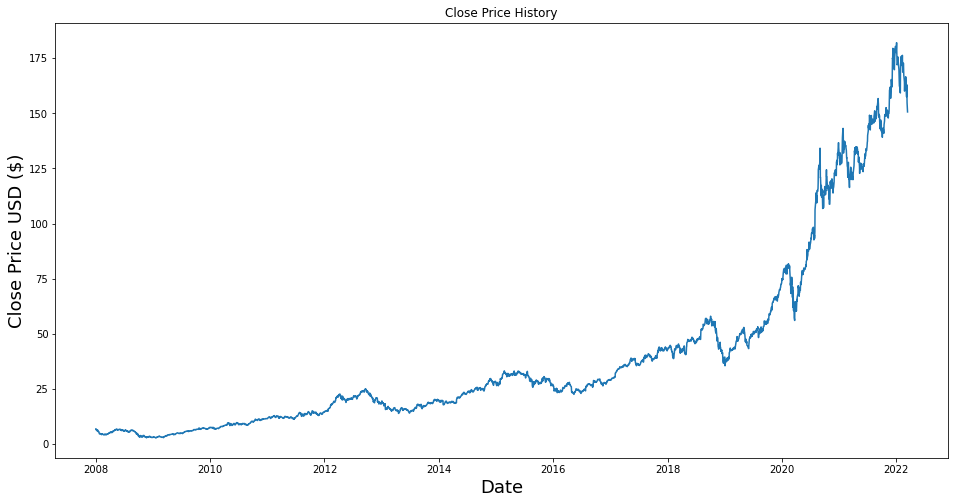

In [54]:
#Plotting the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(data['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

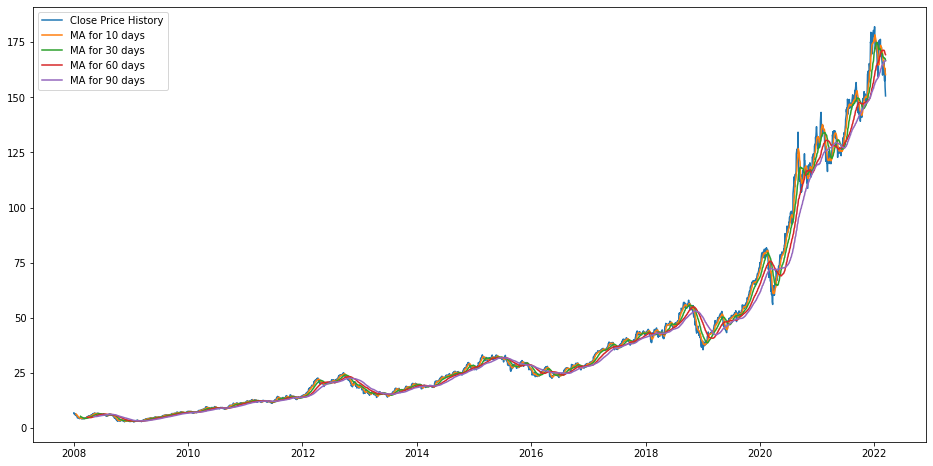

In [55]:
#Plot the moving average of the stock to select the best timestep for the LSTM model
ma_day = [10,30,60, 90, 120, 180]

for ma in ma_day:
    column_name = "MA for %s days" %(str(ma))
    data[column_name] = data['Close'].rolling(ma).mean()

#Plot the moving average of the stock
plt.figure(figsize=(16,8))
plt.plot(data['Close'], label='Close Price History')
for ma in ma_day:
    column_name = "MA for %s days" %(str(ma))
    plt.plot(data[column_name], label=column_name)
plt.legend(loc='upper left')
plt.show()

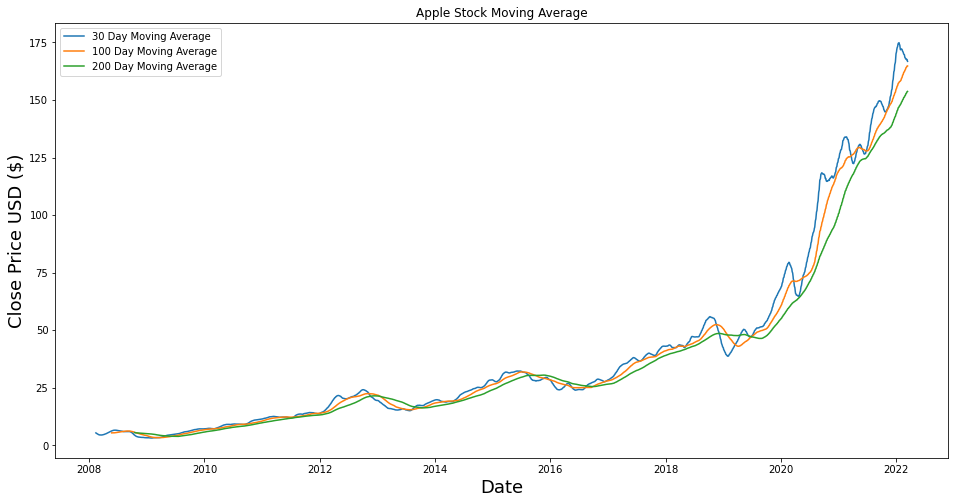

In [56]:
#Plot the moving average of the stock
plt.figure(figsize=(16,8))
plt.title('Apple Stock Moving Average')
plt.plot(data['Close'].rolling(window=30).mean(), label='30 Day Moving Average')
plt.plot(data['Close'].rolling(window=100).mean(), label='100 Day Moving Average')
plt.plot(data['Close'].rolling(window=200).mean(), label='200 Day Moving Average')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend(loc='upper left')
plt.show()

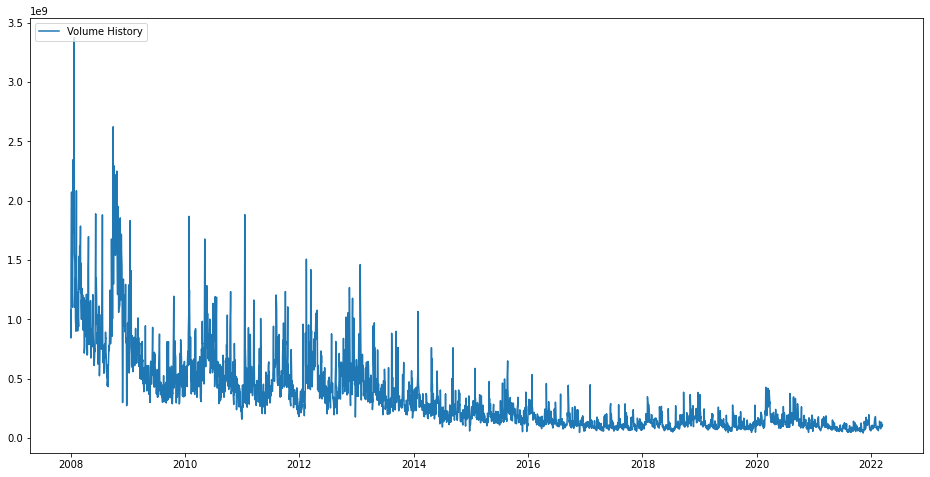

In [57]:
#Plot the volume of the stock
plt.figure(figsize=(16,8))
plt.plot(data['Volume'], label='Volume History')
plt.legend(loc='upper left')
plt.show()

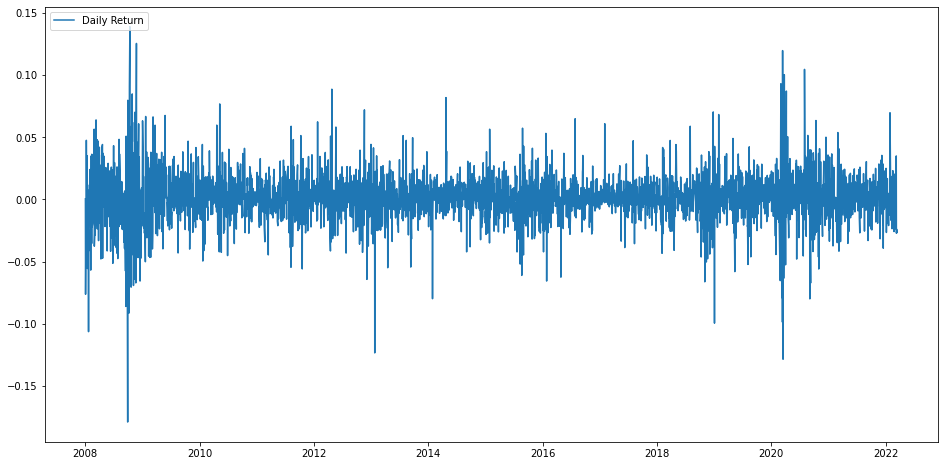

In [58]:
#plot the daily return of the stock
data['Daily Return'] = data['Close'].pct_change()
plt.figure(figsize=(16,8))
plt.plot(data['Daily Return'], label='Daily Return')
plt.legend(loc='upper left')
plt.show()

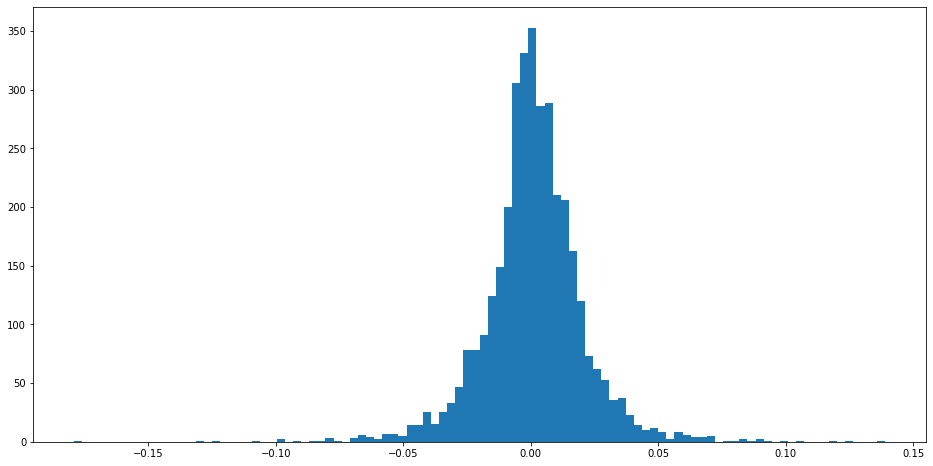

In [59]:
#plot a histogram of the daily return of the stock
plt.figure(figsize=(16,8))
plt.hist(data['Daily Return'].dropna(), bins=100)
plt.show()


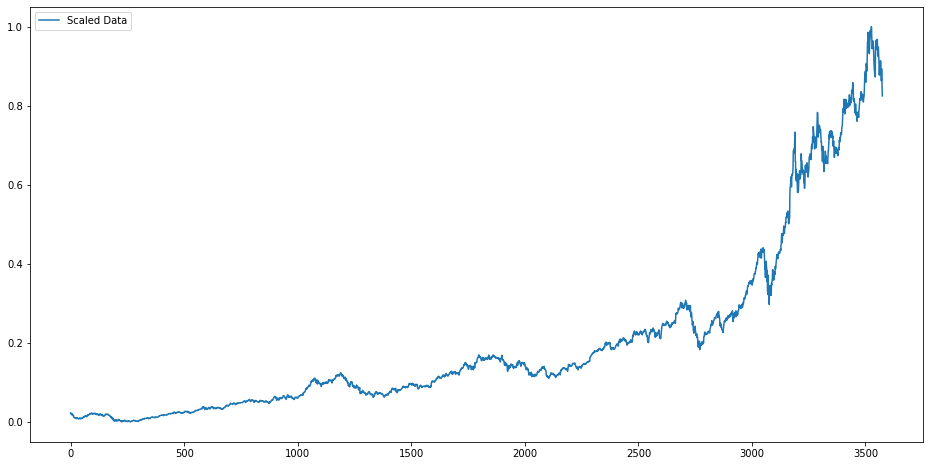

In [60]:
#Scale the data and plot the scaled data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

#plot the scaled data from day 0 to current day
plt.figure(figsize=(16,8))
plt.plot(scaled_data, label='Scaled Data')
plt.legend(loc='upper left')
plt.show()

In [61]:
scaled_data.shape

(3575, 1)

In [62]:
data.shape

(3575, 11)

In [63]:
print(scaled_data)

[[0.02324395]
 [0.02326189]
 [0.02029661]
 ...
 [0.86893   ]
 [0.84778242]
 [0.82484934]]


Get the data

In [64]:
#Create a new dataframe with only the 'Close' column
data = data.filter(['Close'])

#Convert the dataframe to a numpy array
dataset = data.values

#Get the number of rows to train the model on (80% of the data)
training_size = int(np.ceil( len(scaled_data) * .8 ))
test_size = int(np.ceil( len(scaled_data) * .2 ))

#2860 is 80 percent of the total number of rows in the dataset
print("Total Rows in Training Dataset: ", training_size)
print("Total Rows in Testing Dataset: ", test_size)

Total Rows in Training Dataset:  2860
Total Rows in Testing Dataset:  715


In [65]:
#Split the data in to training and testing data, 80% training and 20% testing starting from the beginning of the dataset
train_data = scaled_data[0:training_size , :]
test_data = scaled_data[training_size:len(scaled_data), :]

#remove null values
train_data = train_data[~np.isnan(train_data).any(axis=1)]
test_data = test_data[~np.isnan(test_data).any(axis=1)]

#print the shape of the training and testing data
print("Training Data Shape: ", train_data.shape)
print("Testing Data Shape: ", test_data.shape)

Training Data Shape:  (2860, 1)
Testing Data Shape:  (715, 1)


In [66]:
#Time step is the number of days we want to look back to predict the next closing price
#We need use the training data to create the x_train and y_train data sets where x_train is the closing price of the previous 14 years and y_train is the closing price of the next day
#if data is 120, 130, 125, 140, 134, and 150 then x_train would be 120, 130, 125, 140, 134 and y_train would be 150
#We will do the same for the test data and then check the accuracy of the model

#Function to create the x_train and y_train data sets
def create_dataset (dataset, time_step=1):
    dataX, dataY = [], []
    #Loop through the data and create the x_train and y_train data sets
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0] #Start from 0 to time_step and add to a
        dataX.append(a) #Store the values from 0 to time_step in dataX
        dataY.append(dataset[i+time_step, 0]) #Store the value of the next day in dataY
    return np.array(dataX), np.array(dataY) #Return the training data and the testing data as numpy arrays

In [67]:
#time step is the number of days we want to look back to predict the next closing price and we will use 10 days for this model
time_step = 10

#Create the training data set
x_train, y_train = create_dataset(train_data, time_step)

#180 features and 2550 rows
print (x_train.shape) #the training data should have 10 features for 10 days
print (y_train.shape)

(2849, 10)
(2849,)


In [68]:
time_step = 10

#Create the testing data set
x_test, y_test = create_dataset(test_data, time_step)

#180 features an 730 rows
print(x_test.shape)
print(y_test.shape)

(704, 10)
(704,)


In [69]:
#Reshape the data to fit the LSTM model
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

Predict Closing Stock Price 

Scale the data 

Creating the training and test dataset

We have time series data so we should divide the data between the dates as the next data (date) is depended on the previous day. 

In [70]:
model = Sequential()
#Add the first LSTM layer and c
model.add(LSTM(256, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))

#One final output layer
model.add(Dense(1))

#Compile the model with the adam optimizer and mean squared error loss function
model.compile(optimizer='adam', loss='mean_squared_error')


In [71]:
#Fit the model
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=40, batch_size=64, verbose=1)

Epoch 1/40
45/45 [==============================] - 24s 210ms/step - loss: 0.0013 - val_loss: 7.2500e-04
Epoch 2/40
45/45 [==============================] - 5s 102ms/step - loss: 3.1382e-05 - val_loss: 0.0019
Epoch 3/40
45/45 [==============================] - 6s 130ms/step - loss: 2.9591e-05 - val_loss: 0.0014
Epoch 4/40
45/45 [==============================] - 7s 147ms/step - loss: 2.8728e-05 - val_loss: 0.0018
Epoch 5/40
45/45 [==============================] - 6s 123ms/step - loss: 3.0242e-05 - val_loss: 0.0021
Epoch 6/40
45/45 [==============================] - 5s 117ms/step - loss: 3.0907e-05 - val_loss: 9.6373e-04
Epoch 7/40
45/45 [==============================] - 5s 107ms/step - loss: 3.6162e-05 - val_loss: 0.0015
Epoch 8/40
45/45 [==============================] - 6s 131ms/step - loss: 2.7447e-05 - val_loss: 0.0014
Epoch 9/40
45/45 [==============================] - 5s 106ms/step - loss: 3.3584e-05 - val_loss: 0.0021
Epoch 10/40
45/45 [==============================] - 6s 123

In [72]:
train_predict = model.predict(x_train)
train_predict = scaler.inverse_transform(train_predict)


90/90 [==============================] - 4s 23ms/step


In [73]:
test_predict = model.predict(x_test)
test_predict = scaler.inverse_transform(test_predict)


22/22 [==============================] - 1s 23ms/step


In [74]:
#Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(train_predict - y_test)**2)
print(rmse)

21.6533812252801


In [75]:
print(test_predict.shape), print (train_predict.shape)

(704, 1)
(2849, 1)


(None, None)

In [76]:
#test_predict

In [77]:
print(train_predict.shape)

(2849, 1)


<ipython-input-80-1a5153e74e04>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = test_predict


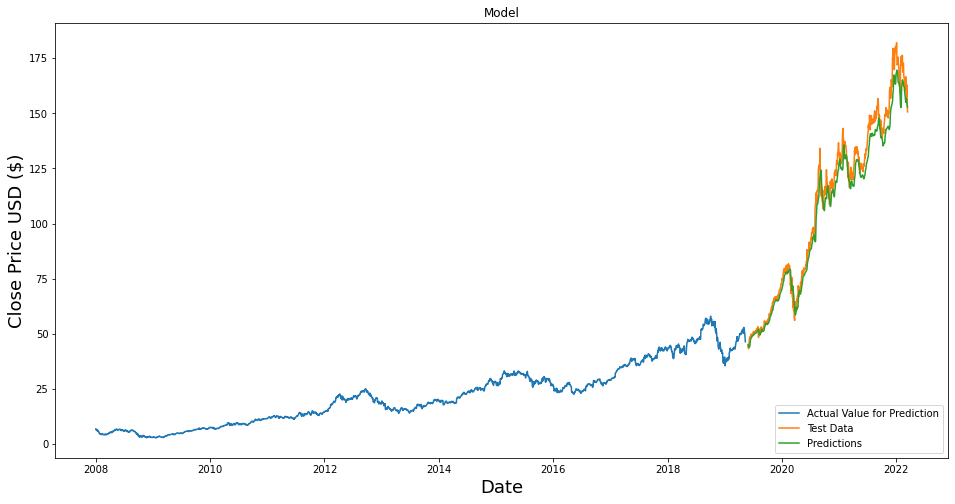

In [80]:
#plot the training data and the model predictions
train = data[:training_size]
valid = data[training_size+11:]
valid['Predictions'] = test_predict
#valid['train'] = train_predict

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Actual Value for Prediction', 'Test Data', 'Predictions'], loc='lower right')
plt.show()
